## RQ4: Cross project prediction
## Deliverables
1. Confusion matrix for each learner x 1  = 1 CM.
2. Performance metrics (Accuracy, Precision and Recall) for each learner x 1 learners = 1 rows of metrics.
3. AUC-ROC curve for all learners x 1 graph = 1 AUC-ROC graph.

## Learners
1. XGBoost Classifier

## Feature set
1. RFE

## Datasets
1. Apache Tomcat
2. Apache Struts2-core



In [1]:
# Basic imports
import numpy as np
import pandas as pd
import sys

# Data preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Feature selection
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import RFE

# Handling imbalance data
from imblearn.over_sampling  import RandomOverSampler
from imblearn.under_sampling  import RandomUnderSampler

# CV
from sklearn.model_selection import StratifiedKFold

# Performance metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_validate
from matplotlib import pyplot as plt
from numpy import mean
from sklearn.metrics import ConfusionMatrixDisplay as CMD
from sklearn.metrics import roc_curve

#ML models
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

def label_encode(train, test, target):
    print('Labelled target found..')
    train_target = train.copy()
    test_target = test.copy()
    df = train.append(test, ignore_index=True)
    le = LabelEncoder()
    le.fit(df[target])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    train_target[target] = le.transform(train[target])
    test_target[target] = le.transform(test[target])
    print('Encoded...')
    return train_target, test_target, le_name_mapping

def fit_feature_set(feature_set):
    global X_ros
    X_ros = X_ros[feature_set]
    global test_X
    test_X = test_X[feature_set]
  
def predict(model, target):
    kfold = StratifiedKFold(n_splits=10)
    cv_model = cross_validate(model,X_ros,y_ros,cv=kfold,return_estimator=True)
    scores = list(cv_model['test_score'])
    idx = scores.index(max(cv_model['test_score']))
    cv_model = cv_model['estimator'][idx]
    predictions = cv_model.predict(test_X)
    pred_proba = cv_model.predict_proba(test_X)
    average = ''
    if target != 0:
      average = 'micro'
    else:
      average = 'binary'
    accuracy = accuracy_score(test_Y, predictions)
    precision = precision_score(test_Y, predictions, average=average)
    recall = recall_score(test_Y, predictions,average=average)
    return [accuracy, precision, recall,pred_proba ,predictions]

def train_test_split():
  df1 = pd.read_csv(ds[0])
  df2 = pd.read_csv(ds[1])
  return df1, df2

### Experiments

In [23]:
target = 2

ds = ["./datasets/tomcat-final.csv", "./datasets/struts-final.csv"]
np.set_printoptions(threshold=np.inf)
pd.set_option('max_columns', None)

test, train= train_test_split()
targets = ['vulnerable','severity','title']

feature_columns = test.columns[2:-4]
X, test_X = train[feature_columns], test[feature_columns]
label_mappings= dict()
if not target == 0:
    label_X_train, label_X_test, label_mappings = label_encode(train,test, targets[target])
    y, test_Y = label_X_train.pop(targets[target]), label_X_test.pop(targets[target])
else:
    y, test_Y = train.pop(targets[target]), test.pop(targets[target])
ros = RandomUnderSampler(sampling_strategy='majority')
X_ros, y_ros = ros.fit_resample(X, y)
if len(label_mappings) > 0:
  labels = label_mappings.keys()
  values = label_mappings.values()
  print(pd.DataFrame([labels, values]).T)

Labelled target found..
Encoded...
                                                    0   1
0                                                   0   0
1   AJP Request Injection and potential Remote Cod...   1
2                           Access Restriction Bypass   2
3                             Arbitrary File deletion   3
4                             Authentication weakness   4
5                   Cross-site Request Forgery (CSRF)   5
6                                Cross-site scripting   6
7                      DIGEST Authentication weakness   7
8                             Denial of Service (DoS)   8
9                                                 DoS   9
10           Frame injection in documentation Javadoc  10
11                                         HTTP/2 DoS  11
12                              HTTP/2 request mix-up  12
13                       Improper Action Name Cleanup  13
14                             Information Disclosure  14
15                        Limited dir

### Machine learning

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  UserWarning,



-----Model: XGBoost Classifier-----
Accuracy: 0.18669149353194825
Precision: 0.18669149353194825
Recall: 0.18669149353194825


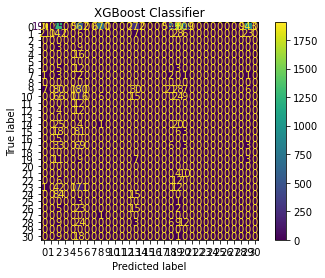

In [24]:
# Random Feature Eliminator
rfe = RFE(estimator=DecisionTreeClassifier())
rfe.fit(X_ros, y_ros)
rfe_features = []
for i in range(X.shape[1]):
    if(rfe.support_[i] == 1):
        rfe_features.append(X.columns[i])
fit_feature_set(rfe_features)

#XGBoost Classifier 
if target == 0:
  xgb = XGBClassifier(n_estimators=500, objective='binary:logistic')
else:
  xgb = XGBClassifier(n_estimators=500,objective='multi:softmax')
xgb_pred_arr = predict(xgb,target)
xgb_pred = xgb_pred_arr[-2]
print('\n-----Model: XGBoost Classifier-----')
print(f'Accuracy: {mean(xgb_pred_arr[0])}')
print(f'Precision: {mean(xgb_pred_arr[1])}')
print(f'Recall: {mean(xgb_pred_arr[2])}')
xgb_fig = CMD.from_predictions(test_Y,xgb_pred_arr[-1])
xgb_fig.ax_.set_title('XGBoost Classifier')
print(xgb_fig)

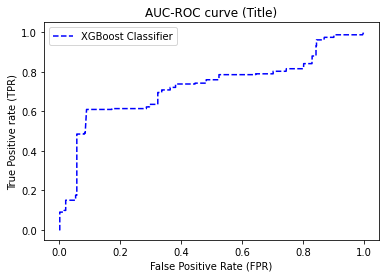

In [25]:
# roc curve for models
fpr = {}
tpr = {}
thresh ={}
    
fpr1, tpr1, thresh1 = roc_curve(test_Y, xgb_pred[:,1], pos_label=1)
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(test_Y))]
p_fpr, p_tpr, _ = roc_curve(test_Y, random_probs, pos_label=1)

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--', color='blue', label='XGBoost Classifier')

# title
plt.title('AUC-ROC curve ('+targets[target].capitalize()+')')
# x label
plt.xlabel('False Positive Rate (FPR)')
# y label
plt.ylabel('True Positive rate (TPR)')

plt.legend(loc='best')
plt.show();